In [2]:
!pip install polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00


In [4]:
%run Polygon_API.ipynb

In [6]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# First Attemp: MLP

In [382]:
#Note: run the following to obtain VOO_smooth_0.8.csv:
# df = get_all_features('VOO', '2022-01-01', '2025-01-31', alpha = 0.8, smoothing = True, d = 7)
# df.('VOO_smooth_0.8.csv')

df_train = pd.read_csv('VOO_smooth_0.8.csv', index_col = 0)
df_train = df_train.drop('Target', axis = 1)
df_val = get_all_features('OPK', '2022-01-01', '2025-01-31', alpha = 0.8, smoothing = True, d = 7)
df_val = df_val.drop('Target', axis = 1)

In [267]:
# create target values
# target indicates whether or not stock price will rise after 7 days
# i.e. if target = 1 at Jan 1, 2025, then price will be higher on Jan 8, 2025

df_train['Target'] = (df_train['Close'].shift(-7) - df_train['Close']).apply(np.sign)
df_val['Target'] = (df_val['Close'].shift(-7) - df_val['Close']).apply(np.sign)

df_train = df_train.dropna()
df_val = df_val.dropna()

In [240]:
# unsmooth data for graphical comparison
df_unsmooth = single_stock_table('VOO', '2022-01-01', '2025-01-31')

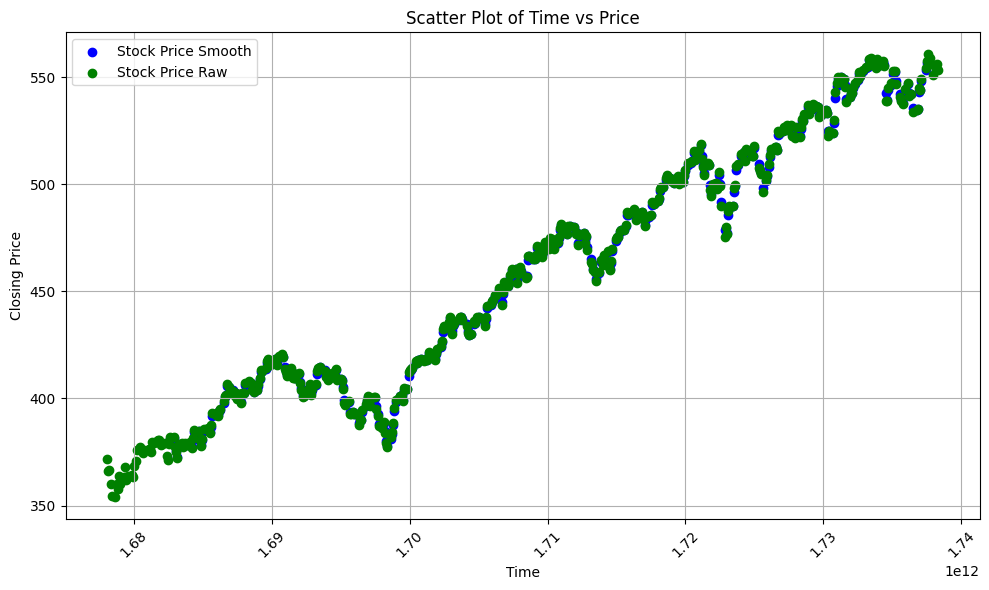

In [241]:
import matplotlib.pyplot as plt

# Create scatter plot for both series
plt.figure(figsize=(10, 6))
plt.scatter(df_train['Timestamp'], df_train['Close'], color = 'blue', label = 'Stock Price Smooth')
plt.scatter(df_unsmooth['Timestamp'], df_unsmooth['Close'], color = 'green', label = 'Stock Price Raw')
# plt.scatter(df['Timestamp'], df['Target'], color = 'red', label = 'Target')

# Customize the plot
plt.title('Scatter Plot of Time vs Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [268]:
df_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]
df_val = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]

le = LabelEncoder()

y_train = le.fit_transform(df_train['Target'])
X_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_train = np.array(X_train, dtype = np.float32)

y_val = le.fit_transform(df_val['Target'])
X_val = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_val = np.array(X_val, dtype = np.float32)

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3)

In [276]:
model = keras.models.Sequential([
    layers.Input((10,)),  # each input has 3 features
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(2)     # output layer, represents the three species labels
])

In [261]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 531,970 (2.03 MB)

 Trainable params: 531,970 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [277]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
model.compile(optimizer= "adam", loss = loss_fn, metrics = ["accuracy"])

In [278]:
history = model.fit(X_train, y_train, epochs = 100,  validation_data = (X_val, y_val), verbose = 1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5603 - loss: 28.3838 - val_accuracy: 0.5885 - val_loss: 1.1037
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4908 - loss: 2.8761 - val_accuracy: 0.5885 - val_loss: 1.7246
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5126 - loss: 3.1670 - val_accuracy: 0.5885 - val_loss: 2.3302
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5660 - loss: 1.3046 - val_accuracy: 0.4460 - val_loss: 0.9174
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5469 - loss: 0.8162 - val_accuracy: 0.5885 - val_loss: 1.4723
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5315 - loss: 1.1420 - val_accuracy: 0.5885 - val_loss: 1.1867
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5508 - loss: 0.8333 - val_accuracy: 0.5517 - val_loss: 0.6907
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5977 - loss: 0.6897 - val_accuracy: 0.5885 -

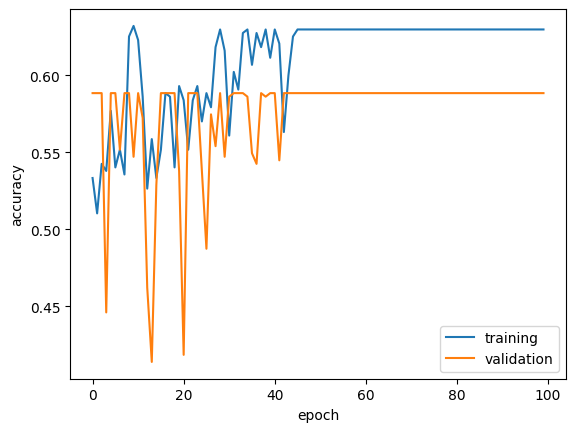

In [279]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Second Attempt: 1D CNN

In [324]:
alpha = 0.8   # exponential smoothing parameter
d = 7         # number of days for prediction

df_train = pd.read_csv('VOO_smooth_0.8.csv', index_col = 0)
df_val = get_all_features('CMG', '2022-01-01', '2025-01-31', alpha = 0.8, smoothing = True, d = 7)

In [325]:
df_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]
df_val = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]

le = LabelEncoder()

y_train = le.fit_transform(df_train['Target'])
X_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_train = np.array(X_train, dtype = np.float32)

y_val = le.fit_transform(df_val['Target'])
X_val = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_val = np.array(X_val, dtype = np.float32)

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3)

In [326]:
from keras import datasets, layers, models
from scipy.signal import convolve2d

# Define the model
model = models.Sequential([
    layers.Input((10, 1)),  # Input shape: (14, 1)
    layers.Conv1D(32, kernel_size=4, activation='relu', padding='same'),  # 1D convolution
    layers.MaxPooling1D(pool_size=2),  # 1D pooling
    layers.Conv1D(64, kernel_size=4, activation='relu', padding='same'),  # 1D convolution
    layers.MaxPooling1D(pool_size=2),  # 1D pooling
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)  # Number of classes
])

In [321]:
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 10, 32)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 5, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,802 (65.63 KB)

 Trainable params: 16,802 (65.63 KB)

 Non-trainable params: 0 (0.00 B)

In [337]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9252 - loss: 0.1969 - val_accuracy: 0.7014 - val_loss: 2.2898
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9368 - loss: 0.1461 - val_accuracy: 0.6923 - val_loss: 2.3302
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9426 - loss: 0.1368 - val_accuracy: 0.6742 - val_loss: 2.4110
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9425 - loss: 0.1576 - val_accuracy: 0.6742 - val_loss: 2.5074
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9347 - loss: 0.1667 - val_accuracy: 0.6810 - val_loss: 2.7189
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9331 - loss: 0.1469 - val_accuracy: 0.6968 - val_loss: 2.6058
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.0981 - val_accuracy: 0.7059 - val_loss: 2.7702
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.1012 - val_accuracy: 0.6946 -

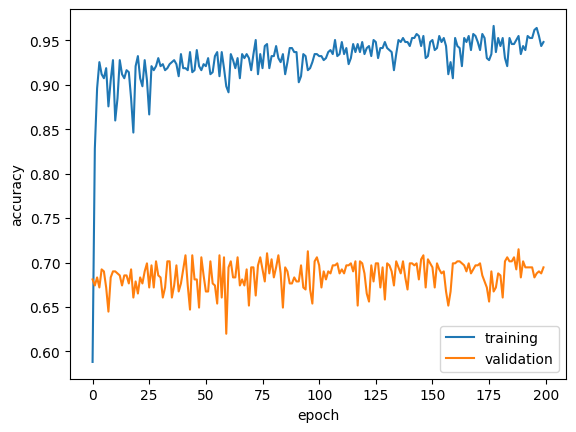

In [328]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Third Attempt: 2D CNN

In [368]:
alpha = 0.8   # exponential smoothing parameter
d = 7         # number of days for prediction

df_train = pd.read_csv('VOO_smooth_0.8.csv', index_col = 0)
df_val = get_all_features('CMG', '2022-01-01', '2025-01-31', alpha = 0.8, smoothing = False, d = 7)

In [371]:
X_training = []
y_training = []
X_validation = []
y_validation = []

for start in range(0, len(df) - 14):
  end = start + 14
  window = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']].iloc[start: end].to_numpy()
  target = df_train['Target'].iloc[end]
  X_training.append(window)
  y_training.append(target)

for start in range(0, len(df) - 14):
  end = start + 14
  window = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']].iloc[start: end].to_numpy()
  target = df_val['Target'].iloc[end]
  X_validation.append(window)
  y_validation.append(target)

X_training = np.array(X_training, dtype = np.float32)
y_training = le.fit_transform(y_training)

X_validation = np.array(X_validation, dtype = np.float32)
y_validation = le.fit_transform(y_validation)

In [380]:
model = models.Sequential([
    layers.Input((14, 10, 3)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (7, 10), padding = 'same',activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10) # number of classes
])

In [376]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 10, 32)          │           6,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 5, 32)            │          71,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 2, 64)            │         143,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247,178 (965.54 KB)

 Trainable params: 247,178 (965.54 KB)

 Non-trainable params: 0 (0.00 B)

In [381]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_training,
                    y_training,
                    epochs=20,
                    validation_data=(X_validation, y_validation))

RuntimeError: Unable to automatically build the model. Please build it yourself before calling fit/evaluate/predict. A model is 'built' when its variables have been created and its `self.built` attribute is True. Usually, calling the model on a batch of data is the right way to build it.
Exception encountered:
'Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Traced<ShapedArray(float32[32,14,10])>with<DynamicJaxprTrace(level=1/0)>. Expected shape (None, 14, 10, 3), but input has incompatible shape (32, 14, 10)[0m

Arguments received by Sequential.call():
  • inputs=jnp.ndarray(shape=(32, 14, 10), dtype=float32)
  • training=False
  • mask=None'